In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from CLPmodel import *

from fastmri.data.subsample import RandomMaskFunc
from fastmri.data import subsample
from fastmri.data import transforms, mri_data

import torch.cuda

from fastmri.evaluate import *

In [2]:
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])

def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format

    ifft_kspace = fastmri.ifft2c(T.to_tensor(kspace))
    crop_kspace = T.complex_center_crop(ifft_kspace, (320,320))   #torch.Size([640, 372, 2])
    orig_kspace = fastmri.fft2c(crop_kspace)
    masked_kspace, mask = T.apply_mask(orig_kspace, mask_func)  # apply the mask to k-space
                                                                # undersampled k-space data
    mr_img =  fastmri.ifft2c(masked_kspace)    # undersampled MR image
    
    return mr_img, masked_kspace, mask, target

dataset = mri_data.SliceDataset(
    root=pathlib.Path('./tresette'),
    transform=data_transform,
    challenge='singlecoil'
)

Epoch n° (1) loss: 0.002
Average psnr:  22.45185237371621
Average ssim:  0.4212639461107114
Epoch n° (2) loss: 0.002
Average psnr:  22.362727065046293
Average ssim:  0.4175535100786125
Epoch n° (3) loss: 0.002
Average psnr:  22.412709280222405
Average ssim:  0.42037913704118807
Epoch n° (4) loss: 0.002
Average psnr:  22.377863539367162
Average ssim:  0.4176514521241188
Epoch n° (5) loss: 0.002
Average psnr:  22.387755692506037
Average ssim:  0.42014492988711644
Epoch n° (6) loss: 0.002
Average psnr:  22.367221459621142
Average ssim:  0.4180375736425905


<timed exec>:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch n° (7) loss: 0.002
Average psnr:  22.315466518161678
Average ssim:  0.4168375023022419
Epoch n° (8) loss: 0.002
Average psnr:  22.429629946957114
Average ssim:  0.421517813218241
Epoch n° (9) loss: 0.002
Average psnr:  22.38387054755908
Average ssim:  0.4207837447492766
Epoch n° (10) loss: 0.002
Average psnr:  22.360688101343747
Average ssim:  0.4176617835750099
Finished Training
Average psnr tot:  22.384978452450085
Average ssim tot:  0.4191831392729107
CPU times: user 48min 11s, sys: 5min 34s, total: 53min 46s
Wall time: 29min 21s


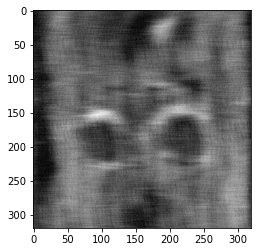

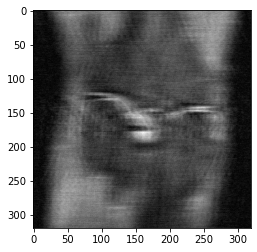

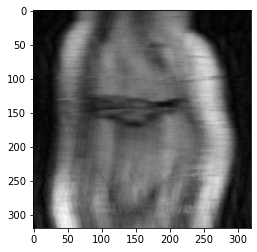

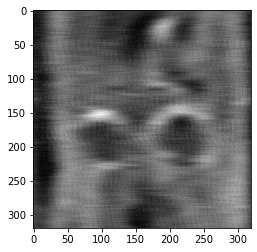

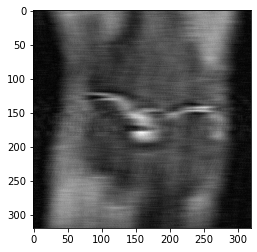

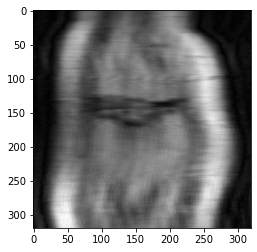

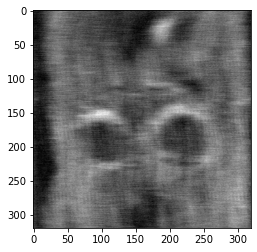

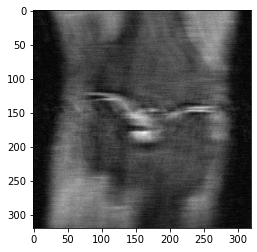

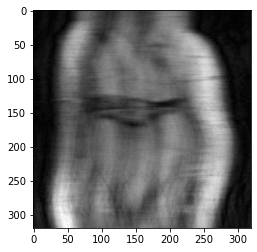

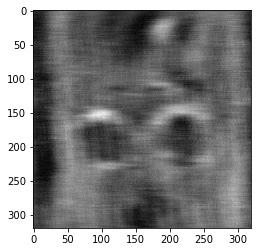

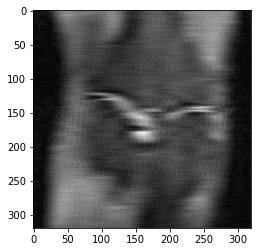

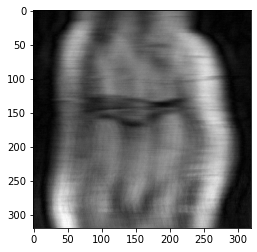

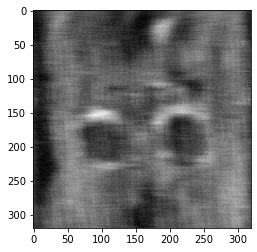

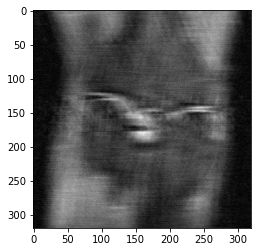

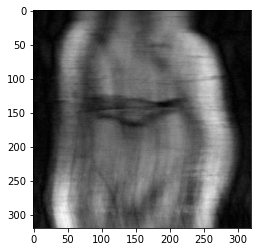

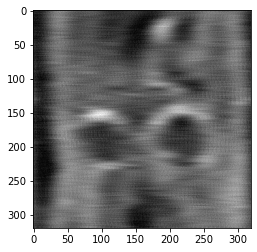

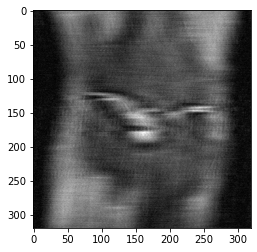

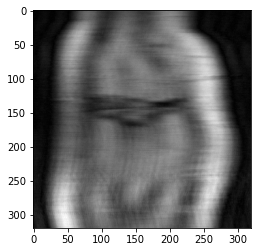

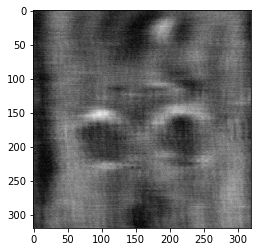

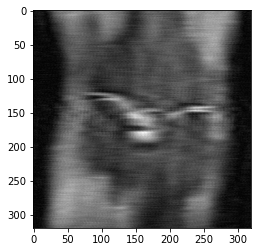

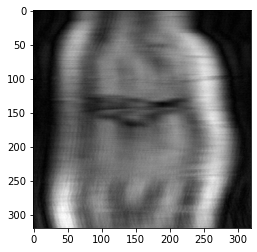

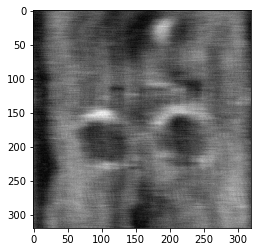

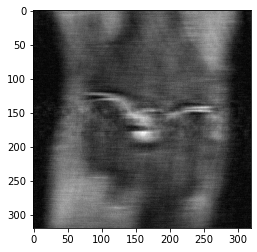

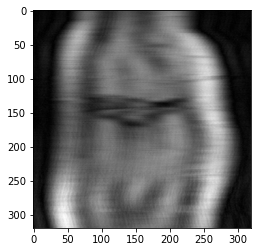

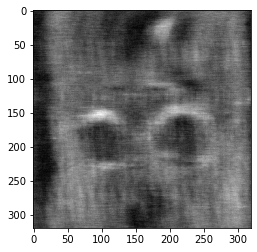

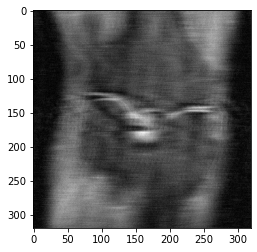

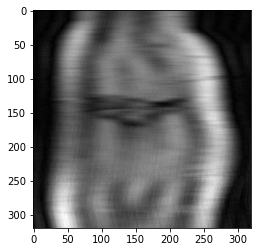

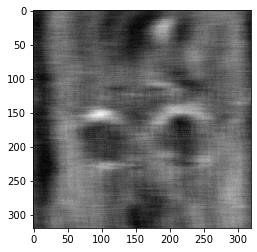

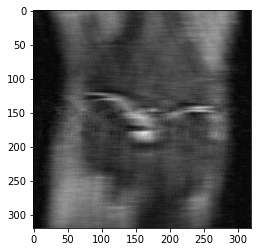

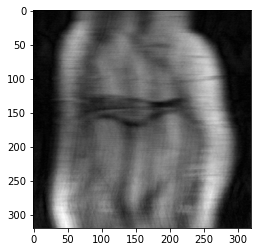

In [3]:
%%time
import torch.optim as optim

net = Net().cuda()

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.95, amsgrad=False)

psnr = PSNR()
ssim = SSIM()

avg_psnr_f = 0.0
avg_ssim_f = 0.0

for epoch in range(10):  # loop over the dataset multiple times
    
    running_loss = 0.0
    count_slice = 0
    avg_psnr = 0.0
    avg_ssim = 0.0
    
    for mr_img, masked_kspace, mask, target in dataset:
        
        input1 = mr_img.unsqueeze(0).unsqueeze(0)
        input2 = masked_kspace.unsqueeze(0).unsqueeze(0)

        outputs = net(input1.cuda(), input2.cuda(), mask.cuda())

        abs1 = fastmri.complex_abs(outputs[0][0])
        abs2 = transforms.to_tensor(target).cuda()

        loss = criterion(abs1, abs2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()

        avg_psnr += psnr(abs1, abs2).item()
        avg_ssim += ssim(abs1, abs2).item()
        
        count_slice += 1
        if(count_slice%30==0):
            fig = plt.figure()
            plt.imshow(abs1.cpu().detach().numpy(), cmap='gray')
            plt.savefig('outfin/rmi'+str(count_slice)+'.jpg')
        pass

    avg_psnr_f += avg_psnr/count_slice
    avg_ssim_f += avg_ssim/count_slice
    
    print('Epoch n° (%d) loss: %.3f' % (epoch + 1, running_loss))
    
    print("Average psnr: ", avg_psnr /count_slice)
    print("Average ssim: ", avg_ssim /count_slice)
    
print('Finished Training')
print("Average psnr tot: ", avg_psnr_f /10)
print("Average ssim tot: ", avg_ssim_f /10)

In [4]:
PATH = './saved_net.pth'
torch.save(net.state_dict(), PATH)

In [5]:
print(count_slice)

119
